In [32]:
import gymnasium as gym
import matplotlib.pyplot as plt

import torch

from importlib import reload
from copy import deepcopy

import utils.plots_cliffwalking as plots
from env.cliff_walking import WindyCliffWalking


# Resolvendo o ambiente Cliff Walking com Deep Q-Learning

O [Cliff Walking](https://gymnasium.farama.org/environments/toy_text/cliff_walking/) é um dos mais simples ambientes de aprendizado por reforço (RL), sendo ideal para entender o funcionamento do QLearning tabular, um dos algoritmos mais fundamentais para iniciantes. A ideia do Cliff Walking é simples: o agente deve ser capaz de atravessar um tabuleiro do início ao fim tomando cuidado para não cair em um penhasco. Se o agente cair no penhasco, ele retorna para o início do tabuleiro e leva uma penalidade de recompensa.

<img src="media/cliff_walking.gif" width="200">

Abaixo seguem algumas informações importantes para a modelagem do ambiente como um Processo de Decisão de Markov (MDP):

### Espaço de ações

O espaço de ações é discreto e contém os inteiros do intervalo {0, 3}. Uma ação deve indicar a direção de um movimento:
* 0: Cima
* 1: Direita
* 2: Baixo
* 3: Esquerda

### Espaço de estados

O estado representa a posição do jogador no tabuleiro. Logo, o espaço de estados também é discreto e contém os inteiros do intervalo {0, 47}. O valor numérico da posição do agente no tabuleiro pode ser obtido como linha_atual * nlinhas + coluna, sendo que as linhas e colunas começam em 0.



### Conversão de inteiro para (x,y)

A rede neural fica mais simples se receber como entrada um par (x,y) em vez de um inteiro. Se fossemos alimentá-la com um inteiro, teríamos que converter esse inteiro para um one-hot. Como são 48 estados, precisaríamos de um vetor de 48 elementos, sendo 47 elementos zerados! Ao passarmos um par (x,y), o vetor fica reduzido para apenas dois elementos. A função abaixo codifica o estado para a posição do agente.

In [33]:
def encode_state(state) -> torch.Tensor:
    x = state % 12
    y = state // 12
    return torch.tensor([x, y], dtype=torch.float32)

## Criando o modelo

No Deep Q-Learning, os Q-valores de cada ação associados a um estado são calculados através de uma rede neural. Ou seja, a rede neural recebe como entrada um vetor de estados e deve retornar o vetor de Q-valores onde cada elemento representa o Q-valor da ação i. Um Q-valor pode ser interpretado como "a recompensa acumulada total esperada por executar a ação A no estado S e depois seguir a mesma política até o final do episódio".

Por se tratar de um problema relativamente simples, o modelo para solucionar o CliffWalking pode ser uma rede MLP simples com uma única camada oculta. Além disso, note que a predição dos Q-valores é uma tarefa de regressão, portanto não há necessidade de softmax no final da rede. 

In [34]:
class Qnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Linear(2, 128) # entrada: posicao (x, y)
        self.layer2 = torch.nn.Linear(128, 4)

    def forward(self, x: int):
        x = encode_state(x)
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        return x

## Amostrando ações com a política $\epsilon$-greedy

No final do treinamento, espera-se que a melhor ação para cada estado seja aquela cujo QValor é o maior. No entanto, para que o QLearn convirja adequadamente, é necessário que no início do treinamento o agente "explore" bem o ambiente. Isto é, que ele visite um grande número de estados mesmo que não sejam necessariamente ótimos. Uma técnica amplamente utilizada para essa finalidade é a política $\epsilon$-greedy. Ela consiste em forçar o agente a escolher ações aleatoriamente com uma frequência que diminui conforme o treinamento avança.

In [35]:
def get_action(model, epsilon, state, n_actions=4):
    if torch.rand(1) < epsilon:
        return torch.randint(n_actions, (1,)).item()
    qvals = model(state)
    return torch.argmax(qvals).item()

## Treinamento da rede neural 

A cada passo do treinamento, o agente executará uma ação e utilizará a informação retornada pelo ambiente para calcular uma loss e atualizar seus pesos de forma a minimizá-la. A loss que será utilizada é o erro quadrático médio entre o Q-valor escolhido e o maior Q-valor do próximo estado calculado utilizando a rede com os pesos anteriores à ultima atualização:

$$L_i(\theta_i)=\mathbb{E}[(y_i - Q(s,a;\theta_i))^2]$$
$$y_i=\mathbb{E}[R(s')+\gamma\max_A Q(s',A;\theta_{i-1})]$$

Note que, portanto, serão necessárias duas redes neurais com a mesma arquitetura, mas uma terá os pesos deefasados em uma iteração com relação à outra.

In [40]:
def update_q_net(model: torch.nn.Module, 
                 model_target: torch.nn.Module,
                 optimizer: torch.optim.Optimizer, 
                 state, action, reward, next_state, terminated, gamma):

    optimizer.zero_grad()
    prediction = model(state)[action]

    # se o estado é terminal, o valor é a recompensa
    with torch.no_grad():
        target = reward + gamma * torch.max(model_target(next_state)) if not terminated else torch.tensor(reward, dtype=torch.float32) 
    
    loss = torch.nn.functional.mse_loss(prediction, target)
    loss.backward()

    # atualizando os pesos da rede defasada
    model_target.load_state_dict(model.state_dict())

    # atualizando os pesos da rede
    optimizer.step()

    return model, model_target

## Loop de treinamento

No loop de treinamento, juntaremos todas as funções desenvolvidas até o momento. A ideia principal é definir um número máximo de episódios (estágio inicial até o estágio final) para que o agente colete experiências do ambiente e otimize sua tabela de QValores.

In [41]:
def train(env: gym.Env, 
          model,
          n_episodes=5000, # numero maximo de episodios
          epsilon=0.99, # probabilidade inicial de escolher uma ação aleatória
          epsilon_decay=0.99, # fator de decaimento da probabilidade de escolher uma ação aleatória
          learning_rate=0.0005, # taxa de aprendizado
          gamma=0.99, # fator de desconto
          verbose=False):
    
    model_target = deepcopy(model)

    # inicializando os pesos das redes
    for nn in [model, model_target]:
        for layer in [nn.layer1, nn.layer2]:
            torch.nn.init.xavier_uniform_(layer.weight)
            layer.bias.data.fill_(0.01)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        step = 0
        done = False

        if epsilon > 0.001:
            epsilon *= epsilon_decay
        
        while not done and step < 500: # 1000 steps max
            action = get_action(model, state, epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            model, model_target = update_q_net(model, model_target, optimizer, state, action, reward, next_state, terminated, gamma)
            state = next_state
            total_reward += reward

            done = terminated or truncated
            step += 1
            
        if episode % 100 == 0 and verbose:
            print(f"Episode {episode} - Total reward: {total_reward} - epsilon: {epsilon}")

    return model

## Treinando

Está tudo configurado, portanto agora podemos rodar o algoritmo!

In [42]:
cliff_walking = gym.make('CliffWalking-v0')
q_net = Qnet()
trained_q_net = train(cliff_walking, q_net, n_episodes=2000, verbose=True)

Episode 0 - Total reward: -6638 - epsilon: 0.9801
Episode 100 - Total reward: -995 - epsilon: 0.358748297681892
Episode 200 - Total reward: -1688 - epsilon: 0.1313134793282883
Episode 300 - Total reward: -5648 - epsilon: 0.048064980279267165
Episode 400 - Total reward: -6440 - epsilon: 0.017593337264871736
Episode 500 - Total reward: -5693 - epsilon: 0.006439730429870554
Episode 600 - Total reward: -5153 - epsilon: 0.0023571496064139765
Episode 700 - Total reward: -4163 - epsilon: 0.000993147795920851
Episode 800 - Total reward: -5054 - epsilon: 0.000993147795920851
Episode 900 - Total reward: -4559 - epsilon: 0.000993147795920851
Episode 1000 - Total reward: -6143 - epsilon: 0.000993147795920851
Episode 1100 - Total reward: -3645 - epsilon: 0.000993147795920851
Episode 1200 - Total reward: -5252 - epsilon: 0.000993147795920851
Episode 1300 - Total reward: -4559 - epsilon: 0.000993147795920851
Episode 1400 - Total reward: -5846 - epsilon: 0.000993147795920851
Episode 1500 - Total rewar

## Testando o agente

A função abaixo rodará um episódio com o agente já treinado.

In [ ]:
def test(env: gym.Env, 
          q_table,
          n_episodes=1,
          verbose=False
          ):
    
    total_rewards = []
    for episode in range(n_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        
        while not done:
            action = get_action(q_table, state, 0)
            state, reward, terminated, truncated, _ = env.step(action)
            total_reward += reward

            done = terminated or truncated

        if verbose:
            print(f"Episode {episode} - Total reward: {total_reward}")
            
        total_rewards.append(total_reward)

    env.close()
    return torch.mean(total_reward)

#test(gym.make('CliffWalking-v0', render_mode="human"), trained_q_net)

## Análise de resultados

### Visualizando a política

A célula abaixo permitirá observar a ação mais provável de ser tomada em cada uma das posições do tabuleiro.

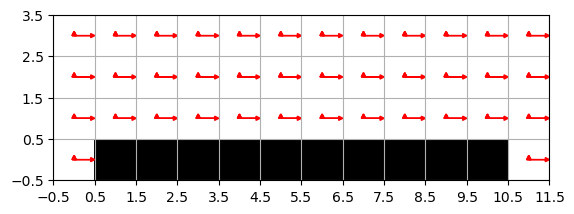

<Figure size 640x480 with 0 Axes>

In [45]:
reload(plots)
plots.plot_arrows_from_qnet(trained_q_net)

### Visualizando a influência da taxa de aprendizado

A célula abaixo criará um gráfico com a recompensa total média de um conjunto de agentes treinados com uma diferente taxa de aprendizado. Como você explicaria os resultados?

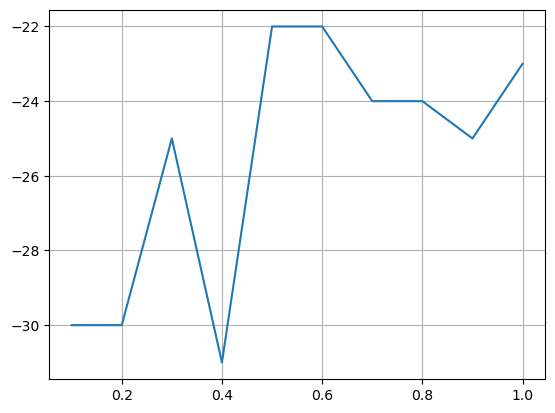

In [ ]:
# retorno médio esperado em função de alpha

def plot_avg_return_x_alpha(n_samples=100, n_alphas=10 ):
    avg_returns = []
    alphas=np.linspace(0.1, 1, n_alphas)
 
    for alpha in alphas:
        q_table = new_q_table(n_states=48, n_actions=4)
        trained_q_table = train(cliff_walking, q_table, alpha=alpha)
        avg_returns.append(test(cliff_walking, trained_q_table, n_samples))

    plt.plot(alphas, avg_returns)
    plt.grid()
    plt.show()

plot_avg_return_x_alpha(n_samples=100, n_alphas=10)

## Exercício - ambientes não-determinísticos

Agora que já vimos que o agente aprendeu um caminho para o objetivo que minimiza a distância caminhada e não cai no penhasco, está na hora de deixar as coisas um pouco mais difíceis. Utilizaremos agora uma versão modificada do Cliff Walking que adiciona vento aleatório na direção do penhasco. Ou seja, existe uma probabilidade do agente ser deslocado uma casa para baixo de maneira involuntária.

Essa alteração será interessante para observarmos a infuência da taxa de aprendizado no treinamento de um modelo robusto a ambientes não-determinísticos.

In [ ]:
windy_cliff_walking = WindyCliffWalking(wind=0.5)

windy_q_table = new_q_table(n_states=48, n_actions=4)
trained_windy_q_table = train(cliff_walking, windy_q_table, alpha=0.75, verbose=True)

### Resultados

In [ ]:
windy_cliff_walking.render_mode = 'human'
test(windy_cliff_walking, trained_windy_q_table)

In [ ]:
plots.plot_arrows(trained_q_table)